## Outcome prediction after Chikungunya hospitalization

#### MC853 - Unicamp

- Leandro Henrique Silva Resende – 213437 

- Pietro Grazzioli Golfeto – 223694 

- Yvens Ian Prado Porto – 184031 

### Data Loading

In [1]:
# Required Libraries
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
pd.__version__

'2.2.3'

In [2]:
# Paths to the data (change according to your system)
leandro_path = {
    'sinan_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/source/csv/',
    'cleaned_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets',
    'train_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/train.csv',
}

pietro_path = {
    'sinan_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/source/csv/',
    'cleaned_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/',
    'train_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/train.csv',
}

In [3]:
# Set the path based on the user
if os.path.isdir(leandro_path['sinan_path']):
    path = leandro_path
elif os.path.isdir(pietro_path['sinan_path']):
    path = pietro_path
else:
    raise Exception('Path not found. Please check the paths in the script.')

# SINAN DataSUS CSV files path (modify to match your file path)
sinan_path = os.path.expanduser(path['sinan_path'])

# Cleaned CSV files path (modify to match your file path)
cleaned_path = os.path.expanduser(path['cleaned_path'])

# Set the path to the train data
train_path = os.path.expanduser(path['train_path'])

In [4]:
"""
Load the Chikungunya data from the CSV files
The CSV files are named CHIKBRYY.csv, where YY is the last two digits of the year
The files are stored in the sinan_path directory
The columns in the CSV files are not consistent across all years
We want to identify the columns that are common to all files
"""

# List of last two digits of years for which we have CSV files (2018 to 2025)
start_year = 18
end_year = 25
assert start_year < end_year, "Start year must be less than end year"
years = range(start_year, end_year + 1)

# Dictionary to store the columns for each file
file_columns = {}

# Loop through each year, build the filename, and read the CSV
for year in years:
    file_name = f'{sinan_path}CHIKBR{str(year)}.csv'
    try:
        df = pd.read_csv(file_name, low_memory=False)
        # Save the set of columns for this file
        file_columns[file_name] = set(df.columns)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

# Ensure we have loaded at least one file before proceeding
assert file_columns, "No files were loaded. Please check your file paths."

# Find common columns: the intersection of columns across all files
common_columns = set.intersection(*file_columns.values())
assert common_columns, "No common columns found. Please check your file paths."

print("\nColumns common to all files:")
print(common_columns)

# Compute the union of all columns (all columns that appear in any file)
all_columns = set.union(*file_columns.values())

# For columns that are not common, print which files have them and which don't.
print("\nColumns that are not common among all files:")
for col in all_columns - common_columns:
    # Extract base name (e.g., CHIKBR21) from each file path
    files_with = [os.path.splitext(os.path.basename(fname))[0] 
                    for fname, cols in file_columns.items() if col in cols]
    files_without = [os.path.splitext(os.path.basename(fname))[0] 
                        for fname, cols in file_columns.items() if col not in cols]
    print(f"Column '{col}' is present in files: {files_with} and missing in files: {files_without}")



Columns common to all files:
{'ALRM_HIPOT', 'SANGRAM', 'MANI_HEMOR', 'RESUL_SORO', 'VOMITO', 'EPISTAXE', 'GRAV_SANG', 'HEMATURA', 'CS_SEXO', 'UF', 'RESUL_VI_N', 'CON_FHD', 'RESUL_NS1', 'DT_GRAV', 'DT_OBITO', 'GRAV_TAQUI', 'DT_INTERNA', 'DT_ENCERRA', 'RES_CHIKS2', 'NU_ANO', 'DOR_RETRO', 'NDUPLIC_N', 'AUTO_IMUNE', 'CRITERIO', 'GRAV_AST', 'GRAV_MELEN', 'ALRM_LIQ', 'SG_UF', 'COUFINF', 'HEMATOLOG', 'MUNICIPIO', 'DT_CHIK_S1', 'DT_VIRAL', 'GRAV_EXTRE', 'HISTOPA_N', 'GRAV_METRO', 'DT_NOTIFIC', 'GRAV_CONV', 'Unnamed: 0', 'ALRM_PLAQ', 'ALRM_LETAR', 'TP_NOT', 'ID_MUNICIP', 'SEM_NOT', 'ID_REGIONA', 'ACIDO_PEPT', 'TPAUTOCTO', 'DT_NS1', 'GRAV_ENCH', 'DT_PRNT', 'PLASMATICO', 'IMUNOH_N', 'GRAV_CONSC', 'CS_RACA', 'RENAL', 'CS_GESTANT', 'ALRM_ABDOM', 'LACO', 'GRAV_PULSO', 'PETEQUIAS', 'DOENCA_TRA', 'ALRM_SANG', 'COPAISINF', 'COMUNINF', 'ID_MN_RESI', 'CLINC_CHIK', 'EVOLUCAO', 'DT_CHIK_S2', 'SG_UF_NOT', 'ARTRALGIA', 'ALRM_HEMAT', 'EXANTEMA', 'GRAV_HIPOT', 'TP_SISTEMA', 'ID_AGRAVO', 'NU_IDADE_N', 'ID_OCUP

### Data Cleaning

In [5]:
"""
Remove columns that are not common to all files
Create a new DataFrame with only the common columns
"""

# Load data for all years and save in X dataset
X = []
for year in years:
    file_name = f'{sinan_path}CHIKBR{str(year)}.csv'
    try:
        df = pd.read_csv(file_name, low_memory=False, usecols=common_columns)
        if "Unnamed: 0" in df.columns:
            df = df.drop("Unnamed: 0", axis=1)
        X.append(df)
    except Exception as e:
        print(f"Error loading {file_name}: {e}")
        
X = pd.concat(X, ignore_index=True)

# Display the shape of the dataset
print(f"\nShape of the dataset: {X.shape}")



Shape of the dataset: (1500209, 116)


In [6]:
"""
Filter the data to include only the rows where the pacient was hospitalized ("HOSPITALIZ" column is equal to 1 or to 1.0)
"""

print("\nUnique values in the 'HOSPITALIZ' column:")
print(X['HOSPITALIZ'].value_counts())

# Filter the data to include only the rows where the patient was hospitalized
X = X[(X['HOSPITALIZ'] == 1) | (X['HOSPITALIZ'] == 1.0)]

# Display the shape of the filtered DataFrame
print("\nShape of the filtered X DataFrame: ", X.shape)


Unique values in the 'HOSPITALIZ' column:
HOSPITALIZ
2.0    835678
2       73033
1.0     42802
9.0     30132
1        3629
9        2885
           1
Ø           1
J           1
ï           1
Name: count, dtype: int64

Shape of the filtered X DataFrame:  (42802, 116)


In [7]:
"""
Clean the target variable from the data (EVOLUCAO column)

1- cura
2- óbito pelo
agravo
3- óbito por outras
causas
4- óbito em
investigação
9- ignorado

Remove rows where the target variable is Nan or 9 (ignored)
Only keep rows where the target variable is 1 (cure), 2 (death by the disease), 3 (death by other causes) and 4 (under investigation)
We used 3 and 4 as well to balance the dataset and increase the minority class proportion from 1.8% to 7.5%
"""

# Print the value counts for the 'EVOLUCAO' column in X
print("\nValues for 'EVOLUCAO' in X:")
print(X["EVOLUCAO"].value_counts(dropna=False))

# Filter the data to include only the rows where the target variable is 1 or 2
X = X[(X['EVOLUCAO'] == 1.0) | (X['EVOLUCAO'] == 2.0) | (X['EVOLUCAO'] == 3.0) | (X['EVOLUCAO'] == 4.0)]



Values for 'EVOLUCAO' in X:
EVOLUCAO
1.0    29833
NaN     7354
9.0     3186
3.0     1646
2.0      565
4.0      218
Name: count, dtype: int64


In [8]:
# Remove columns where all values are the same in X (constant columns)
constant_columns = [col for col in X.columns if X[col].nunique() == 1]

# Drop these constant columns from X
X = X.drop(columns=constant_columns)

print("\nDropped constant columns:", constant_columns)


Dropped constant columns: ['TP_NOT', 'ID_AGRAVO', 'ID_PAIS', 'HISTOPA_N', 'IMUNOH_N', 'HOSPITALIZ', 'TP_SISTEMA', 'NDUPLIC_N']


In [9]:
"""
Identify and remove columns with more than 'missing_values_threshold' missing values in X
"""

# Maximum percentage of missing values allowed in a column
missing_values_threshold = 0.01
assert 0.0 <= missing_values_threshold <= 1.0, "missing_values_threshold must be between 0 and 1"

# Compute the percentage of missing values in each column of X
missing_values = X.isnull().mean()

# Print the percentage of missing values in each column of X
print("\nPercentage of missing values in X:")
print(missing_values)


Percentage of missing values in X:
DT_NOTIFIC    0.0
SEM_NOT       0.0
NU_ANO        0.0
SG_UF_NOT     0.0
ID_MUNICIP    0.0
             ... 
PLASMATICO    1.0
EVIDENCIA     1.0
PLAQ_MENOR    1.0
CON_FHD       1.0
COMPLICA      1.0
Length: 108, dtype: float64


In [10]:
# Identify columns with more than 'missing_values_threshold' missing values and drop them
cols_to_drop = missing_values[missing_values > missing_values_threshold].index

X = X.drop(columns=cols_to_drop)
print(f"\nDropped columns (more than {missing_values_threshold * 100}% missing):")
print(list(cols_to_drop))

# Display the shape of the filtered DataFrame
print("\nShape of the filtered X DataFrame: ", X.shape)


Dropped columns (more than 1.0% missing):
['ID_REGIONA', 'ID_UNIDADE', 'CS_ESCOL_N', 'ID_RG_RESI', 'ID_OCUPA_N', 'DT_CHIK_S1', 'DT_CHIK_S2', 'DT_PRNT', 'RES_CHIKS1', 'RES_CHIKS2', 'RESUL_PRNT', 'DT_SORO', 'RESUL_SORO', 'DT_NS1', 'RESUL_NS1', 'DT_VIRAL', 'RESUL_VI_N', 'DT_PCR', 'RESUL_PCR_', 'SOROTIPO', 'DT_INTERNA', 'UF', 'MUNICIPIO', 'TPAUTOCTO', 'COUFINF', 'COPAISINF', 'COMUNINF', 'DOENCA_TRA', 'CLINC_CHIK', 'DT_OBITO', 'DT_ENCERRA', 'ALRM_HIPOT', 'ALRM_PLAQ', 'ALRM_VOM', 'ALRM_SANG', 'ALRM_HEMAT', 'ALRM_ABDOM', 'ALRM_LETAR', 'ALRM_HEPAT', 'ALRM_LIQ', 'DT_ALRM', 'GRAV_PULSO', 'GRAV_CONV', 'GRAV_ENCH', 'GRAV_INSUF', 'GRAV_TAQUI', 'GRAV_EXTRE', 'GRAV_HIPOT', 'GRAV_HEMAT', 'GRAV_MELEN', 'GRAV_METRO', 'GRAV_SANG', 'GRAV_AST', 'GRAV_MIOC', 'GRAV_CONSC', 'GRAV_ORGAO', 'DT_GRAV', 'MANI_HEMOR', 'EPISTAXE', 'GENGIVO', 'METRO', 'PETEQUIAS', 'HEMATURA', 'SANGRAM', 'LACO_N', 'PLASMATICO', 'EVIDENCIA', 'PLAQ_MENOR', 'CON_FHD', 'COMPLICA']

Shape of the filtered X DataFrame:  (32262, 38)


In [11]:
print("Remaining columns in X: ", X.columns)

Remaining columns in X:  Index(['DT_NOTIFIC', 'SEM_NOT', 'NU_ANO', 'SG_UF_NOT', 'ID_MUNICIP',
       'DT_SIN_PRI', 'SEM_PRI', 'NU_IDADE_N', 'CS_SEXO', 'CS_GESTANT',
       'CS_RACA', 'SG_UF', 'ID_MN_RESI', 'DT_INVEST', 'FEBRE', 'MIALGIA',
       'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT',
       'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO',
       'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA',
       'ACIDO_PEPT', 'AUTO_IMUNE', 'CLASSI_FIN', 'CRITERIO', 'EVOLUCAO'],
      dtype='object')


Delete over 20% missing: 45 features left

Delete over 10% missing: 38 features left

Delete over 5% missing: 38 features left

Delete over 2% missing: 38 features left

Delete over 1% missing: 37 features left

In [12]:
X.head()

,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,DT_SIN_PRI,SEM_PRI,NU_IDADE_N,CS_SEXO,CS_GESTANT,...,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,CLASSI_FIN,CRITERIO,EVOLUCAO
35,2018-07-06,201827,2018,12,120040,2018-07-05,201827,4010.0,M,6.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,13.0,1.0,1.0
51,2018-06-29,201826,2018,12,120040,2018-06-24,201826,4029.0,F,5.0,...,1.0,2.0,2.0,2.0,1.0,2.0,2.0,13.0,1.0,1.0
93,2018-09-19,201838,2018,12,120040,2018-09-17,201838,4011.0,F,5.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,13.0,2.0,1.0
115,2018-09-24,201839,2018,12,120040,2018-08-24,201834,4005.0,F,6.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,13.0,1.0,1.0
141,2018-08-16,201833,2018,12,120040,2018-08-13,201833,4011.0,F,5.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,13.0,1.0,1.0


In [13]:
# Count values in the states of the federation column "SG_UF_NOT" in X
print("Values in column 'SG_UF_NOT' in X:\n")
print(X["SG_UF_NOT"].value_counts())

Values in column 'SG_UF_NOT' in X:

SG_UF_NOT
35    4568
31    4541
23    3138
33    2360
50    2191
29    1965
26    1506
21    1275
24    1205
25    1121
51    1078
17     926
52     795
22     745
41     716
27     700
11     623
15     610
32     483
28     394
13     381
43     304
53     259
14     150
16      92
42      80
12      56
Name: count, dtype: int64


In [14]:
# Dictionary definition of the Brazilian states

# Código   UF		Sigla
# 11	Rondônia	RO
# 12	Acre	AC
# 13	Amazonas	AM
# 14	Roraima	RR
# 15	Pará	PA
# 16	Amapá	AP
# 17	Tocantins	TO
# 21	Maranhão	MA
# 22	Piauí	PI
# 23	Ceará	CE
# 24	Rio Grande do Norte	RN
# 25	Paraíba	PB
# 26	Pernambuco	PE
# 27	Alagoas	AL
# 28	Sergipe	SE
# 29	Bahia	BA
# 31	Minas Gerais	MG
# 32	Espírito Santo	ES
# 33	Rio de Janeiro	RJ
# 35	São Paulo	SP
# 41	Paraná	PR
# 42	Santa Catarina	SC
# 43	Rio Grande do Sul (*)	RS
# 50	Mato Grosso do Sul	MS
# 51	Mato Grosso	MT
# 52	Goiás	GO
# 53	Distrito Federal	DF

In [15]:
# Map "SG_UF_NOT" value to the region of Brazil as a new one-hot column use these values:
# "Norte": [11, 12, 13, 14, 15, 16, 17],
# "Nordeste": [21, 22, 23, 24, 25, 26, 27, 28, 29],
# "Centro-Oeste": [50, 51, 52, 53],
# "Sudeste": [31, 32, 33, 35],
# "Sul": [41, 42, 43]

X["REGION_NORTH"] = X["SG_UF_NOT"].isin([11, 12, 13, 14, 15, 16, 17]).astype(int)
X["REGION_NORTHEAST"] = X["SG_UF_NOT"].isin([21, 22, 23, 24, 25, 26, 27, 28, 29]).astype(int)
X["REGION_MIDWEST"] = X["SG_UF_NOT"].isin([50, 51, 52, 53]).astype(int)
X["REGION_SOUTHEAST"] = X["SG_UF_NOT"].isin([31, 32, 33, 35]).astype(int)
X["REGION_SOUTH"] = X["SG_UF_NOT"].isin([41, 42, 43]).astype(int)

# Remove the "SG_UF_NOT" and "ID_MUNICIP" column from X (not needed anymore)
X = X.drop(columns=["SG_UF_NOT", "ID_MUNICIP"])

In [16]:
# Count values in each region
print("\nValues in each region in X:\n")
print("Region North: ", X["REGION_NORTH"].sum())
print("Region Northeast: ", X["REGION_NORTHEAST"].sum())
print("Region Midwest: ", X["REGION_MIDWEST"].sum())
print("Region Southeast: ", X["REGION_SOUTHEAST"].sum())
print("Region South: ", X["REGION_SOUTH"].sum())


Values in each region in X:

Region North:  2838
Region Northeast:  12049
Region Midwest:  4323
Region Southeast:  11952
Region South:  1100


In [17]:
# Remove "SG_UF" and "ID_MN_RESI" columns from X (not useful, redundant values alongside "SG_UF_NOT" and "ID_MUNICIP")
# We will use one-hot encoding of the Regions instead
X = X.drop(columns=["SG_UF", "ID_MN_RESI"])

In [18]:
# Remove rows whose "DT_SIN_PRI" value is lower than July of the year before the first year (first symptoms reported before 2017-07-01 doesn't make sense to go to the hospital after 2018)
previous_year = start_year - 1
X = X[pd.to_datetime(X["DT_SIN_PRI"]) >= pd.to_datetime(f"20{previous_year}-07-01")]

# Save the difference in DAYS between "DT_NOTIFIC" and "DT_SIN_PRI" in a new column called "TIME_DIFF_DAYS"
X["TIME_DIFF_DAYS"] = (pd.to_datetime(X["DT_NOTIFIC"]) - pd.to_datetime(X["DT_SIN_PRI"])).dt.days

# Print min and max values of "TIME_DIFF_DAYS"
print("\nMin and max values of 'TIME_DIFF_DAYS' in X:")
print("Min: ", X["TIME_DIFF_DAYS"].min())
print("Max: ", X["TIME_DIFF_DAYS"].max())


Min and max values of 'TIME_DIFF_DAYS' in X:
Min:  0
Max:  1604


In [19]:
# Print number of rows whose "TIME_DIFF_DAYS" is greater than 180 days
print("\nNumber of rows whose 'TIME_DIFF_DAYS' is greater than 180 days: ", (X["TIME_DIFF_DAYS"] > 180).sum())

# Remove rows whose "TIME_DIFF_DAYS" is greater than 180 days (waited too long to go to the hospital)
# This is a threshold we set to remove outliers
X = X[X["TIME_DIFF_DAYS"] <= 180]

# Remove "DT_SIN_PRI" and "SEM_PRI" columns from X (not useful, redundant values with "TIME_DIFF_DAYS")
X = X.drop(columns=["DT_SIN_PRI", "SEM_PRI"])


Number of rows whose 'TIME_DIFF_DAYS' is greater than 180 days:  94


In [20]:
# Use week and year info to create a new TIME column replacing DT_NOTIFIC, SEM_NOT and NU_ANO
print("Type of SEM_NOT column: ", X["SEM_NOT"].dtype)
print("Type of NU_ANO column: ", X["NU_ANO"].dtype)

# Get min value from "DT_NOTIFIC" column
print("Min value of DT_NOTIFIC column: ", X["DT_NOTIFIC"].min())
start_date = pd.to_datetime(X["DT_NOTIFIC"].min())
print("Start date: ", start_date)

# Calculate difference in weeks from start date
X["TIME"] = (pd.to_datetime(X["DT_NOTIFIC"]) - start_date).dt.days // 7

# Remove DT_NOTIFIC, SEM_NOT and NU_ANO columns
# We will use the TIME column instead
X = X.drop(columns=["DT_NOTIFIC", "SEM_NOT", "NU_ANO"])


Type of SEM_NOT column:  int64
Type of NU_ANO column:  int64
Min value of DT_NOTIFIC column:  2017-12-31
Start date:  2017-12-31 00:00:00


In [21]:
# Check all values in column "CLASSI_FIN" (final classification after investigation)
# 5.0 discarded
# 13.0 confirmed case of Chikungunya

# Map "CLASSI_FIN" value to 1 for confirmed cases and 0 for discarded cases
X["CLASSI_FIN"] = X["CLASSI_FIN"].map({13.0: 1, 5.0: 0})

# Rename "CLASSI_FIN" column to "CONFIRMED_CASE"
X = X.rename(columns={"CLASSI_FIN": "CONFIRMED_CASE"})
print("\nValues in 'CONFIRMED_CASE' column in X:")
print(X["CONFIRMED_CASE"].value_counts())


Values in 'CONFIRMED_CASE' column in X:
CONFIRMED_CASE
0.0    18045
1.0    13890
Name: count, dtype: int64


In [22]:
# Remove "DT_INVEST" column from X (not useful, redundant with "TIME" column)
X = X.drop(columns=["DT_INVEST"])

# Rename "NU_IDADE_N" column to "AGE" column
X = X.rename(columns={"NU_IDADE_N": "AGE"})

# Remove rows whose "AGE" is less than 1000 (undefined, user error) or greater than 4150 (unrealistic, over 150 years)
X = X[(X["AGE"] >= 1000) & (X["AGE"] <= 4150)]

# Modify "AGE" column to have the age in years
# If "AGE" is less than 4000, change to 0 years (hours, days or months old)
# Else, subtract 4000 from the value to get the age in years

X["AGE"] = X["AGE"].apply(lambda x: 0 if x < 4000 else x - 4000)

In [23]:
# Most common years are young people
# Possible outlier at age 0
X["AGE"].value_counts()

AGE
0.0      1508
1.0       708
11.0      587
5.0       560
8.0       555
         ... 
105.0       1
119.0       1
101.0       1
106.0       1
104.0       1
Name: count, Length: 105, dtype: int64

In [24]:
# Print "CS_SEXO" column values
print("Values in 'CS_SEXO' column: ", X["CS_SEXO"].value_counts())

# Keep rows whose "CS_SEXO" is "M" or "F"
X = X[(X["CS_SEXO"] == "M") | (X["CS_SEXO"] == "F")]

# Map "CS_SEXO" value to 1 if "F" and 0 if "M"
X["CS_SEXO"] = X["CS_SEXO"].map({"F": 1, "M": 0})

# Rename column to "GENDER"
X = X.rename(columns={"CS_SEXO": "GENDER"})

Values in 'CS_SEXO' column:  CS_SEXO
F    16921
M    15153
I       10
Name: count, dtype: int64


In [25]:
# Map "CS_GESTANT" value to 1 if 1,2 or 3 (trimester of pregnancy), and 0 if not pregnant or ignored
X["CS_GESTANT"] = X["CS_GESTANT"].map({1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 9: 0})

# Rename column to "PREGNANT"
X = X.rename(columns={"CS_GESTANT": "PREGNANT"})
print("Values in 'PREGNANT' column: ", X["PREGNANT"].value_counts())

Values in 'PREGNANT' column:  PREGNANT
0.0    30945
1.0     1126
Name: count, dtype: int64


In [26]:
# Count values in "CS_RACA" column
print("Values in 'CS_RACA' column: ", X["CS_RACA"].value_counts())

# Bias question: does race influence the outcome of the disease?

# One-hot encode "CS_RACA" column, ignore value 9 (ignored)
X["WHITE"] = X["CS_RACA"].isin([1]).astype(int)
X["BLACK"] = X["CS_RACA"].isin([2]).astype(int)
X["YELLOW"] = X["CS_RACA"].isin([3]).astype(int)
X["BROWN"] = X["CS_RACA"].isin([4]).astype(int)
X["INDIGENOUS"] = X["CS_RACA"].isin([5]).astype(int)

# Remove "CS_RACA" column
X = X.drop(columns=["CS_RACA"])

Values in 'CS_RACA' column:  CS_RACA
4.0    18106
1.0     9048
9.0     3049
2.0     1400
3.0      256
5.0      215
Name: count, dtype: int64


In [27]:
symptoms_columns = ["FEBRE", "MIALGIA", "CEFALEIA", "EXANTEMA", "VOMITO", "NAUSEA", "DOR_COSTAS", "CONJUNTVIT", "ARTRITE", "ARTRALGIA", "PETEQUIA_N", "LEUCOPENIA", "LACO", "DOR_RETRO", "DIABETES", "HEMATOLOG", "HEPATOPAT", "RENAL", "HIPERTENSA", "ACIDO_PEPT", "AUTO_IMUNE"]

# Map symptoms columns to 1 if the value is 1 else 0 (no symptom)
for col in symptoms_columns:
    X[col] = X[col].map({1: 1, 2: 0, 9: 0})

### Train-test split

In [28]:
"""
Train-test split
Split the data into X_train, y_train, X_test, y_test
Use the last {test_years} years for testing and the rest for training
Concatenate all the DataFrames without the last {test_years} years into a single DataFrame called X_train
Concatenate the DataFrames from the last {test_years} years into a single DataFrame called X_test
"""
# Number of years to use for testing
test_years = 2
assert len(years) > test_years, "At least {test_years + 1}  years of data are required."

end_date_train = pd.to_datetime(f"20{end_year - test_years}-12-31")
print("End date train: ", end_date_train)
print("Start date: ", start_date)
print("Difference: ", (end_date_train - start_date).days)
end_date_train = (end_date_train - start_date).days // 7
print("End date train: ", end_date_train)

# Change to datetime
X_train = X[X["TIME"] <= end_date_train]
X_test = X[X["TIME"] > end_date_train]

# Remove the 'EVOLUCAO' column from X_train and save it in y_train
y_train = X_train.pop("EVOLUCAO")

# Remove the 'EVOLUCAO' column from X_test and save it in y_test
y_test = X_test.pop("EVOLUCAO")

# Change the target variable to 0 for cure and 1 for death
y_train = y_train.map({1: 0, 2: 1, 3:1, 4:1})
y_test = y_test.map({1: 0, 2: 1, 3:1, 4:1})

End date train:  2023-12-31 00:00:00
Start date:  2017-12-31 00:00:00
Difference:  2191
End date train:  313


In [29]:
# Maximum number of weeks in the dataset
print("Maximum number of weeks in the dataset: ", X["TIME"].max())

Maximum number of weeks in the dataset:  373


In [30]:
# Values of the y_train and y_test
print("\nValues for 'EVOLUCAO' in y_train:")
print(y_train.value_counts(dropna=True))

print("\nValues for 'EVOLUCAO' in y_test:")
print(y_test.value_counts(dropna=True))


Values for 'EVOLUCAO' in y_train:
EVOLUCAO
0    20140
1     1586
Name: count, dtype: int64

Values for 'EVOLUCAO' in y_test:
EVOLUCAO
0    9548
1     800
Name: count, dtype: int64


In [31]:
X_train.head()

,AGE,GENDER,PREGNANT,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,...,REGION_MIDWEST,REGION_SOUTHEAST,REGION_SOUTH,TIME_DIFF_DAYS,TIME,WHITE,BLACK,YELLOW,BROWN,INDIGENOUS
35,10.0,0,0.0,1,1,1,1,0,1,1,...,0,0,0,1,26,0,0,0,1,0
51,29.0,1,0.0,1,1,1,1,0,1,1,...,0,0,0,5,25,0,0,0,1,0
93,11.0,1,0.0,1,1,1,0,0,0,0,...,0,0,0,2,37,0,0,0,1,0
115,5.0,1,0.0,1,0,1,0,0,1,0,...,0,0,0,31,38,0,0,0,1,0
141,11.0,1,0.0,1,1,1,0,0,0,0,...,0,0,0,3,32,0,0,0,1,0


In [32]:
# Print columns of X_train
print("Columns in X_train: ", X_train.columns)

Columns in X_train:  Index(['AGE', 'GENDER', 'PREGNANT', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA',
       'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA',
       'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES',
       'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT',
       'AUTO_IMUNE', 'CONFIRMED_CASE', 'CRITERIO', 'REGION_NORTH',
       'REGION_NORTHEAST', 'REGION_MIDWEST', 'REGION_SOUTHEAST',
       'REGION_SOUTH', 'TIME_DIFF_DAYS', 'TIME', 'WHITE', 'BLACK', 'YELLOW',
       'BROWN', 'INDIGENOUS'],
      dtype='object')


In [33]:
# Print sum values of each column sorted
print("Sum values of each column in X_train: ")
print(X_train.sum().sort_values(ascending=True))

Sum values of each column in X_train: 
INDIGENOUS                97
YELLOW                   152
ACIDO_PEPT               189
HEMATOLOG                294
HEPATOPAT                333
RENAL                    369
AUTO_IMUNE               374
LACO                     489
PREGNANT               794.0
REGION_SOUTH             816
BLACK                   1010
CONJUNTVIT              1243
DIABETES                1550
REGION_MIDWEST          1647
REGION_NORTH            2213
LEUCOPENIA              2233
PETEQUIA_N              2782
HIPERTENSA              3006
DOR_RETRO               3690
ARTRITE                 3864
EXANTEMA                5561
WHITE                   5568
DOR_COSTAS              5813
VOMITO                  7190
REGION_SOUTHEAST        7377
NAUSEA                  7683
CONFIRMED_CASE        9548.0
REGION_NORTHEAST        9673
ARTRALGIA               9899
GENDER                 11397
CEFALEIA               12565
BROWN                  12586
MIALGIA                14437
FEBR

In [34]:
"""
Save the filtered data to a new CSV file in the cleaned_path directory
"""

# Save the filtered data to a new CSV file in the cleaned_path directory
X_train.to_csv(f'{cleaned_path}X_train.csv', index=False)
y_train.to_csv(f'{cleaned_path}y_train.csv', index=False)

X_test.to_csv(f'{cleaned_path}X_test.csv', index=False)
y_test.to_csv(f'{cleaned_path}y_test.csv', index=False)

In [35]:
X_train.shape

(21726, 38)

In [36]:
X_test.shape

(10348, 38)

In [37]:
# Print the percentage of positive cases in y_train
positive_cases_train = y_train.sum(axis=0)
total_cases_train = y_train.shape[0]
print(f"Number of positive cases in y_train: {positive_cases_train}")
print(f"Number of total cases in y_train: {total_cases_train}")
print(f"Percentage of positive cases in y_train: {positive_cases_train / total_cases_train * 100:.2f}%")

Number of positive cases in y_train: 1586
Number of total cases in y_train: 21726
Percentage of positive cases in y_train: 7.30%


In [38]:
# Print the percentage of positive cases in y_test
positive_cases_test = y_test.sum(axis=0)
total_cases_test = y_test.shape[0]
print(f"Number of positive cases in y_test: {positive_cases_test}")
print(f"Number of total cases in y_test: {total_cases_test}")
print(f"Percentage of positive cases in y_test: {positive_cases_test / total_cases_test * 100:.2f}%")

Number of positive cases in y_test: 800
Number of total cases in y_test: 10348
Percentage of positive cases in y_test: 7.73%


In [39]:
# Merge X and y values into a single DataFrame
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [40]:
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (21726, 39)
Test shape:  (10348, 39)


In [41]:
# Save train and test data to CSV files
train.to_csv(f'{cleaned_path}train.csv', index=False)
test.to_csv(f'{cleaned_path}test.csv', index=False)

### Plots and images

In [42]:
# Load the data from the train_path (adjust the path as needed)
# Not using test data to avoid data leakage
data = pd.read_csv(train_path)

In [43]:
# General plot configuration
sns.set(style="whitegrid")

# Create a mapping to replace the confirmed case values in the legend
case_labels = {0: "Não", 1: "Sim"}

# Mapping to replace the gender values in the legend
gender_labels = {0: "Masculino", 1: "Feminino"}

# Mapping for the Evolution labels
evolution_labels = {0: "Recuperado", 1: "Óbito"}

# Mapping for the regions
region_labels = {
    'REGION_NORTH': 'Norte',
    'REGION_NORTHEAST': 'Nordeste',
    'REGION_MIDWEST': 'Centro-Oeste',
    'REGION_SOUTHEAST': 'Sudeste',
    'REGION_SOUTH': 'Sul'
}

# Columns referring to regions
region_cols = ['REGION_NORTH', 'REGION_NORTHEAST', 'REGION_MIDWEST', 'REGION_SOUTHEAST', 'REGION_SOUTH']

# Columns referring to Race/Color
race_cols = ['WHITE', 'BLACK', 'YELLOW', 'BROWN', 'INDIGENOUS']

# Mapping for the Race/Color labels
race_labels = {
    'WHITE': 'Branco',
    'BLACK': 'Preto',
    'YELLOW': 'Amarelo',
    'BROWN': 'Pardo',
    'INDIGENOUS': 'Indígena'
}

diabetes_labels = {0: "Não", 1: "Sim"}


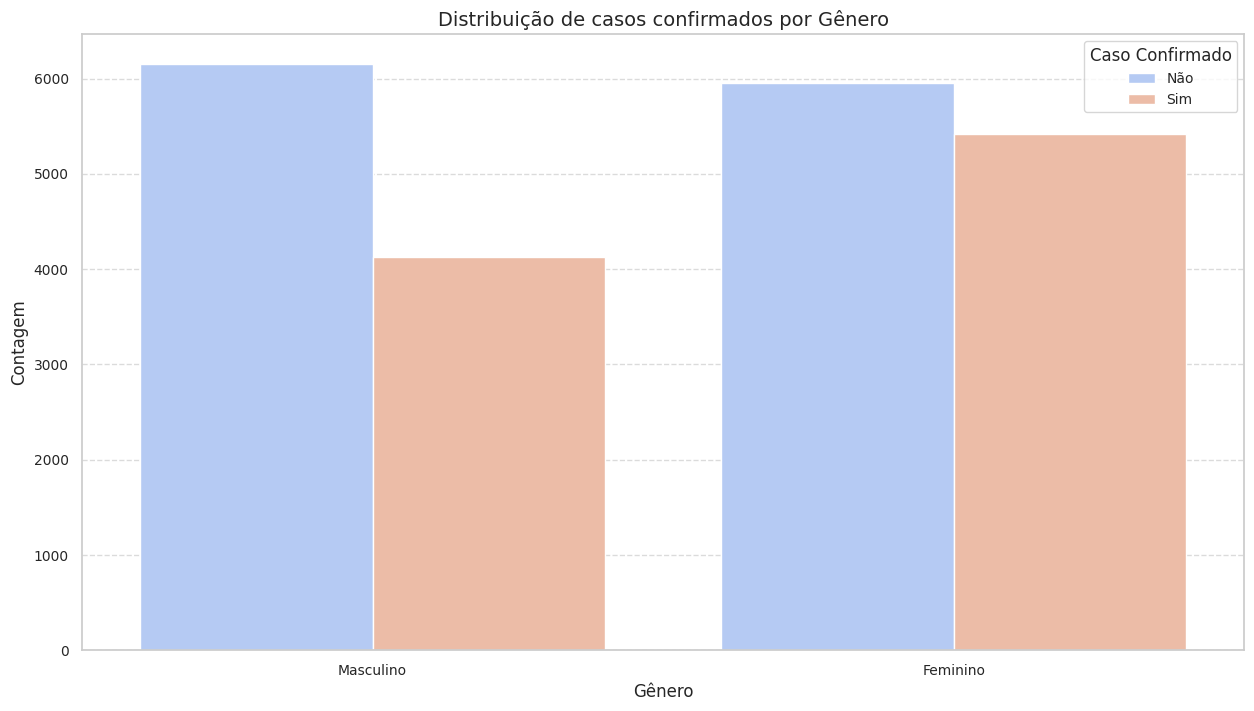

In [44]:
# Bar chart of confirmed cases by gender

plt.figure(figsize=(15, 8))
ax = sns.countplot(
    x=data['GENDER'], 
    hue=data['CONFIRMED_CASE'], 
    palette='coolwarm',
    alpha=1.0
)

# Update the legend to use more intuitive labels
handles, labels = ax.get_legend_handles_labels()
labels = [case_labels[int(float(label))] for label in labels]
plt.legend(handles, labels, title="Caso Confirmado", fontsize=10)

# Fix the x-axis ticks to avoid the warning
ticks = ax.get_xticks()
ax.xaxis.set_major_locator(FixedLocator(ticks))

# Get the current labels and map them to the new gender labels
current_labels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [gender_labels[int(lbl)] for lbl in current_labels]
ax.set_xticklabels(new_labels)

plt.title("Distribuição de casos confirmados por Gênero", fontsize=14)
plt.xlabel("Gênero", fontsize=12)
plt.ylabel("Contagem", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


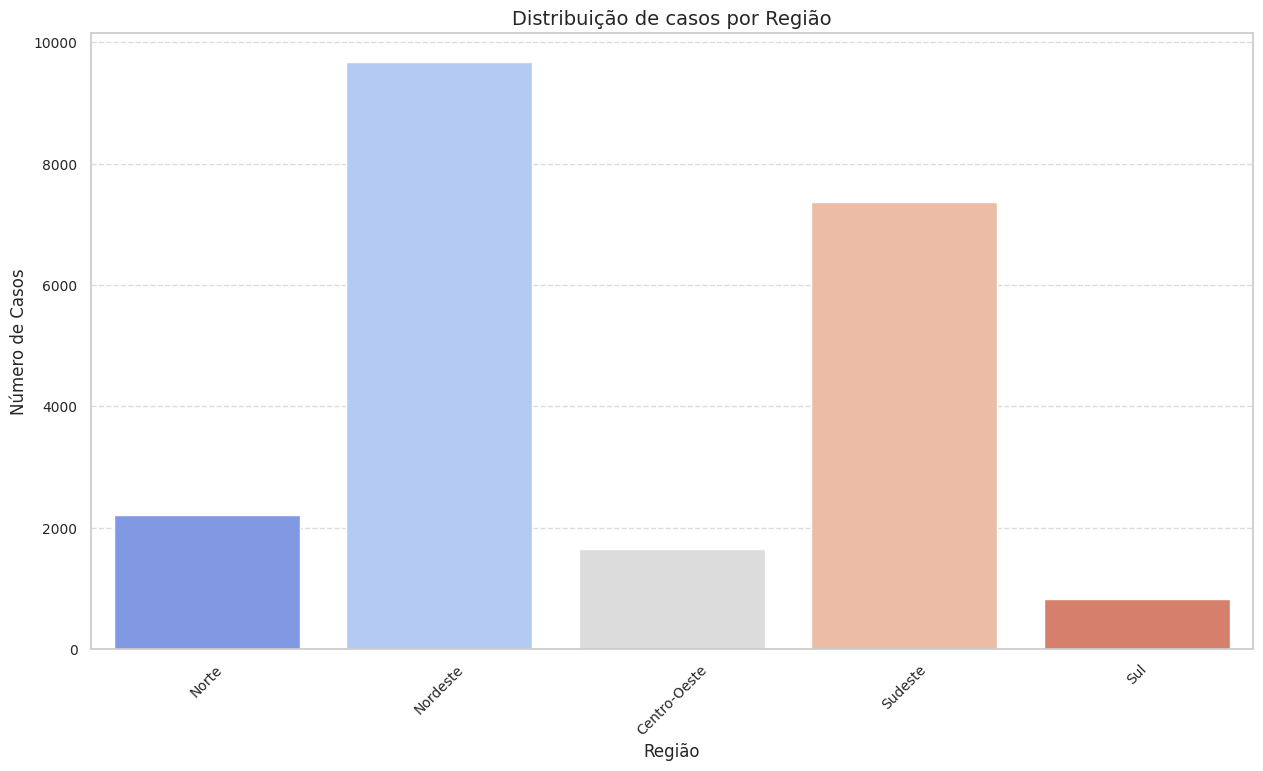

In [45]:
# Bar chart of confirmed cases by region

region_counts = data[region_cols].sum()

plt.figure(figsize=(15, 8))
# Adjustment: Set hue equal to x-axis and remove the legend
ax = sns.barplot(x=region_counts.index, y=region_counts.values, 
                 hue=region_counts.index, palette="coolwarm", legend=False)

plt.title("Distribuição de casos por Região", fontsize=14)
plt.xlabel("Região", fontsize=12)
plt.ylabel("Número de Casos", fontsize=12)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Fix the x-axis ticks to avoid warnings
from matplotlib.ticker import FixedLocator
ticks = ax.get_xticks()
ax.xaxis.set_major_locator(FixedLocator(ticks))

# Get the current labels, map to new ones and update the ticks
current_labels = [label.get_text() for label in ax.get_xticklabels()]
new_labels = [region_labels[label] if label in region_labels else label for label in current_labels]
ax.set_xticklabels(new_labels, rotation=45, fontsize=10)

plt.show()


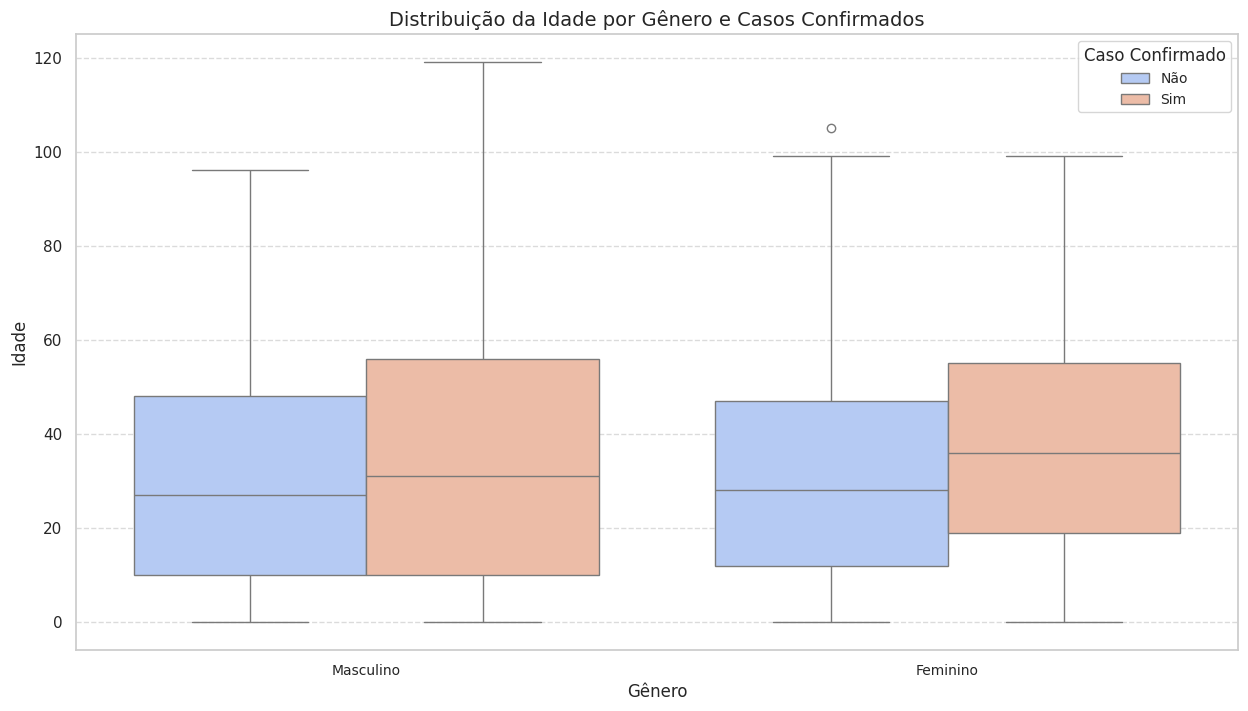

In [46]:
# Boxplot of Age distribution by Gender and Confirmed Cases

plt.figure(figsize=(15, 8))
ax = sns.boxplot(
    x=data['GENDER'], 
    y=data['AGE'], 
    hue=data['CONFIRMED_CASE'], 
    palette='coolwarm'
)

# Update the legend to use the defined labels
handles, labels = ax.get_legend_handles_labels()
# Convert the labels to int and apply the mapping
new_case_labels = [case_labels[int(float(lbl))] for lbl in labels]
plt.legend(handles=handles, labels=new_case_labels, title="Caso Confirmado", fontsize=10)

# Fix the x-axis ticks and update the labels for gender
ticks = ax.get_xticks()
ax.xaxis.set_major_locator(FixedLocator(ticks))
current_gender_labels = [label.get_text() for label in ax.get_xticklabels()]
new_gender_labels = [gender_labels[int(lbl)] for lbl in current_gender_labels]
ax.set_xticklabels(new_gender_labels, fontsize=10)

plt.title("Distribuição da Idade por Gênero e Casos Confirmados", fontsize=14)
plt.xlabel("Gênero", fontsize=12)
plt.ylabel("Idade", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


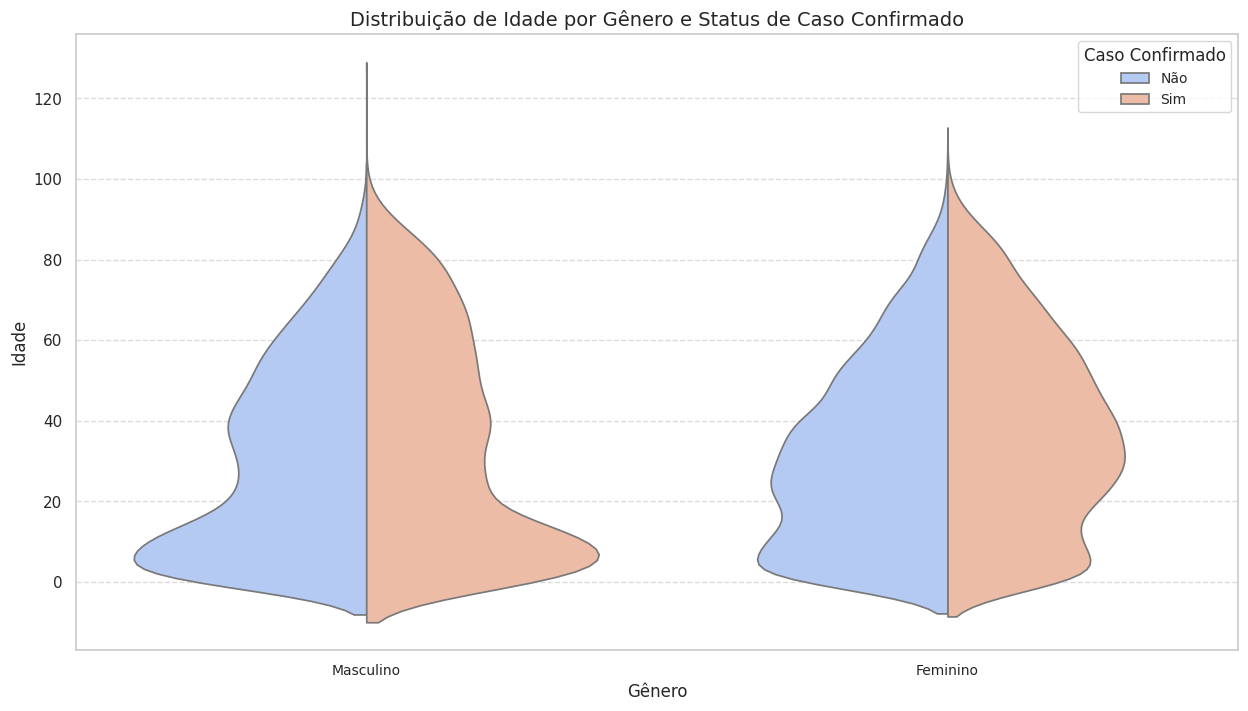

In [47]:
# Violinplot of Age distribution by Gender and Confirmed Cases

plt.figure(figsize=(15, 8))
ax = sns.violinplot(
    x=data['GENDER'], 
    y=data['AGE'], 
    hue=data['CONFIRMED_CASE'], 
    split=True, 
    palette='coolwarm',
    inner=None  # Remove the internal lines of the violinplot
)

# Update the legend to use the defined labels
handles, labels = ax.get_legend_handles_labels()
new_case_labels = [case_labels[int(float(lbl))] for lbl in labels]
plt.legend(handles=handles, labels=new_case_labels, title="Caso Confirmado", fontsize=10)

# Fix the x-axis ticks and update the labels for gender
ticks = ax.get_xticks()
ax.xaxis.set_major_locator(FixedLocator(ticks))
current_gender_labels = [label.get_text() for label in ax.get_xticklabels()]
new_gender_labels = [gender_labels[int(lbl)] for lbl in current_gender_labels]
ax.set_xticklabels(new_gender_labels, fontsize=10)

plt.title("Distribuição de Idade por Gênero e Status de Caso Confirmado", fontsize=14)
plt.xlabel("Gênero", fontsize=12)
plt.ylabel("Idade", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


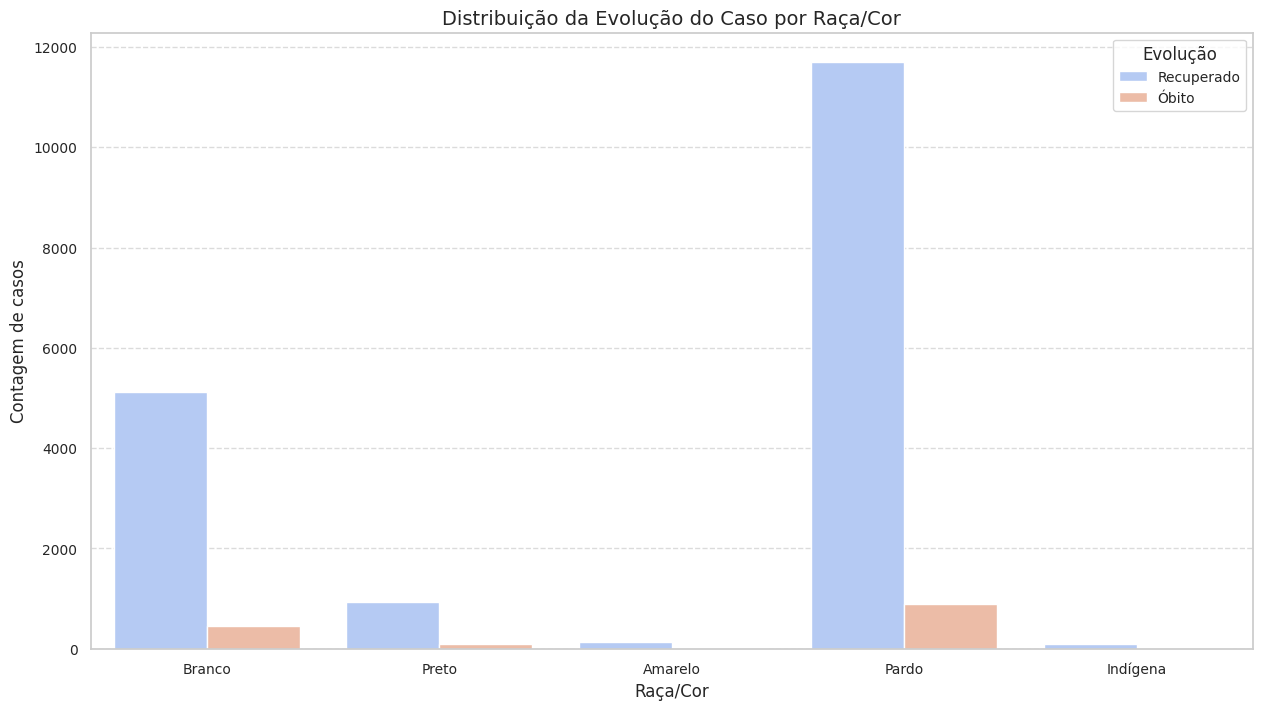

In [48]:
# Bar chart of confirmed cases by Race/Color

# Preprocessing the data for Race/Color
race_data = data[race_cols + ['EVOLUCAO']].melt(id_vars=['EVOLUCAO'], var_name='Race', value_name='Presence')
race_data = race_data[race_data['Presence'] == 1]

plt.figure(figsize=(15, 8))
ax = sns.countplot(
    x='Race', 
    hue='EVOLUCAO', 
    data=race_data, 
    palette='coolwarm'
)

# Update the legend to use the defined labels for Evolution
handles, labels = ax.get_legend_handles_labels()
new_evolution_labels = [evolution_labels[int(float(lbl))] for lbl in labels]
plt.legend(handles=handles, labels=new_evolution_labels, title="Evolução", fontsize=10)

# Fix the x-axis ticks and update the labels for Race/Color
ticks = ax.get_xticks()
ax.xaxis.set_major_locator(FixedLocator(ticks))
current_race_labels = [label.get_text() for label in ax.get_xticklabels()]
new_race_labels = [race_labels[label] if label in race_labels else label for label in current_race_labels]
ax.set_xticklabels(new_race_labels, fontsize=10)

plt.title("Distribuição da Evolução do Caso por Raça/Cor", fontsize=14)
plt.xlabel("Raça/Cor", fontsize=12)
plt.ylabel("Contagem de casos", fontsize=12)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


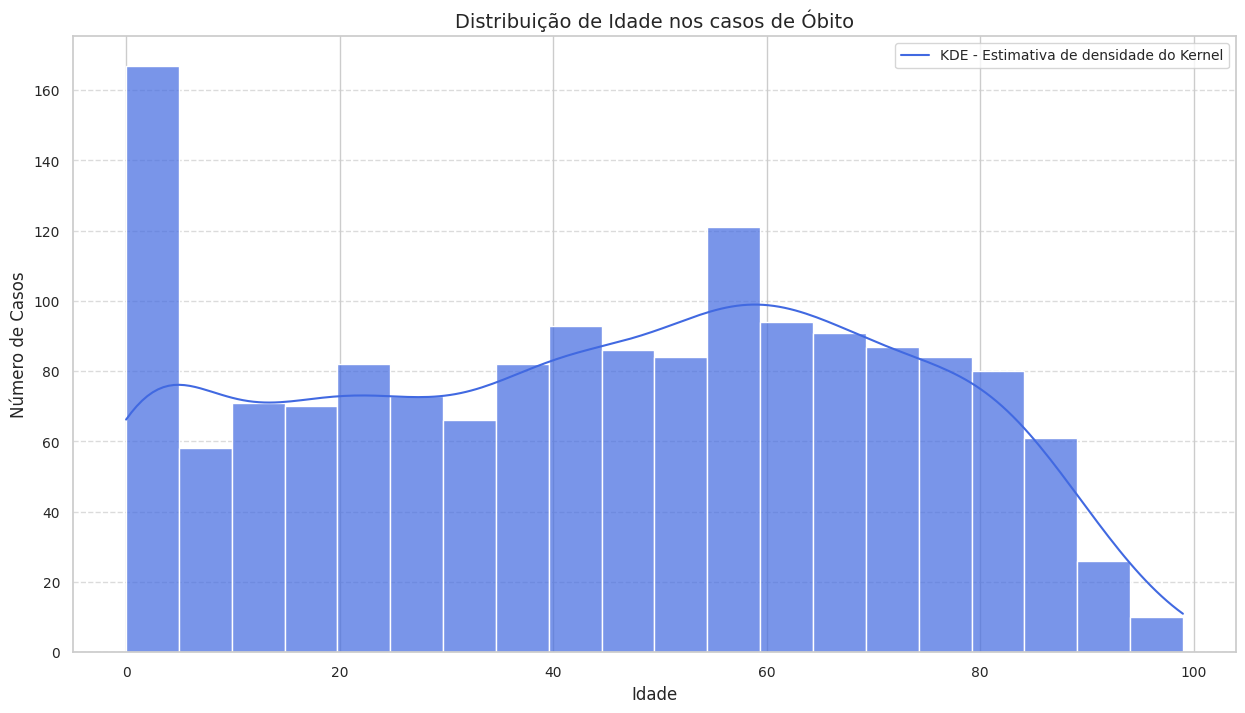

In [49]:
# Histogram of Age in cases with evolution to Death

# Filter the data to include only cases where evolution equals 1 (patient died)
evolucao_data = data[data['EVOLUCAO'] == 1]

plt.figure(figsize=(15, 8))
ax = sns.histplot(
    evolucao_data['AGE'],
    bins=20,
    kde=True,
    color='royalblue',
    alpha=0.7
)
if ax.lines:
    ax.lines[-1].set_label("KDE - Estimativa de densidade do Kernel")
    
plt.title("Distribuição de Idade nos casos de Óbito", fontsize=14)
plt.xlabel("Idade", fontsize=12)
plt.ylabel("Número de Casos", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.show()


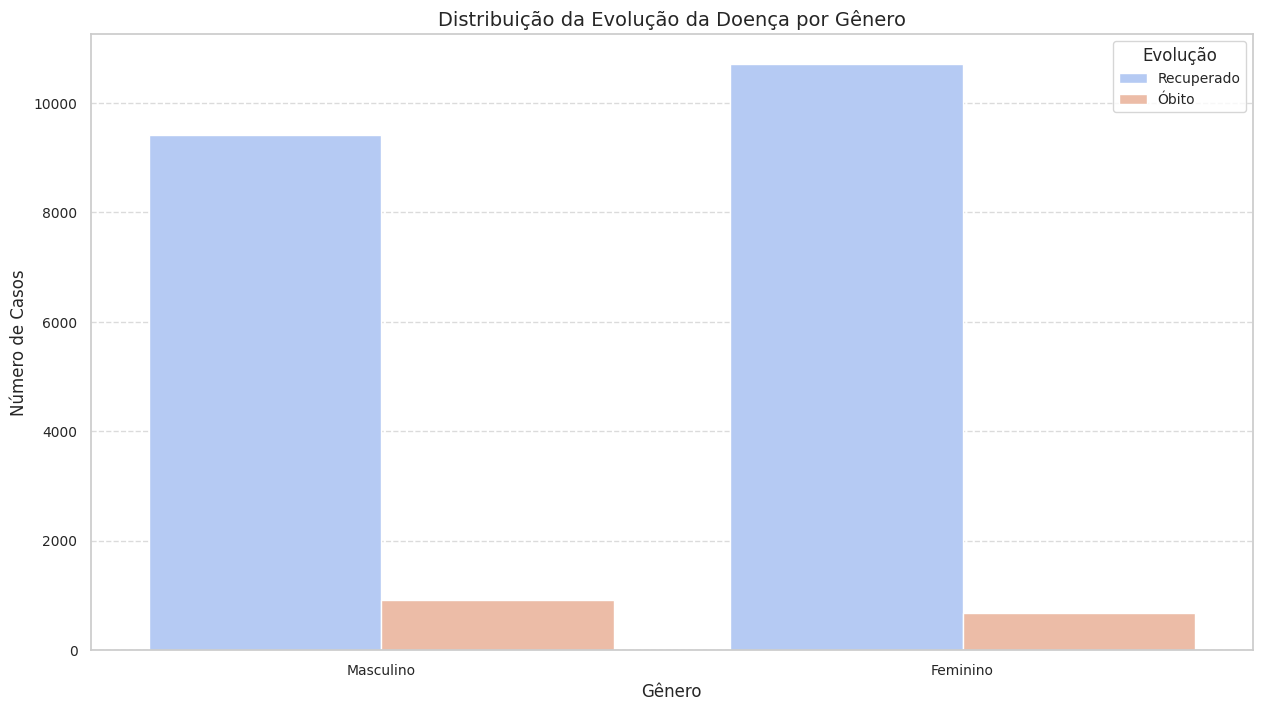

In [50]:
# Bar chart of disease evolution by Gender

plt.figure(figsize=(15, 8))
ax = sns.countplot(x='GENDER', hue='EVOLUCAO', data=data, palette='coolwarm')

# Update the legend to use the defined labels for Evolution
handles, labels = ax.get_legend_handles_labels()
new_evolution_labels = [evolution_labels[int(float(lbl))] for lbl in labels]
plt.legend(handles=handles, labels=new_evolution_labels, title="Evolução", fontsize=10)

# Get the original x-axis labels (should be "0" and "1")
current_gender_labels = [label.get_text() for label in ax.get_xticklabels()]
# Convert to integers for mapping
original_gender_order = [int(lbl) for lbl in current_gender_labels]

# Update the x-axis labels to the mapped names (e.g., Male, Female)
ticks = ax.get_xticks()
ax.xaxis.set_major_locator(FixedLocator(ticks))
new_gender_labels = [gender_labels[gender] for gender in original_gender_order]
ax.set_xticklabels(new_gender_labels, fontsize=10)

plt.title("Distribuição da Evolução da Doença por Gênero", fontsize=14)
plt.xlabel("Gênero", fontsize=12)
plt.ylabel("Número de Casos", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


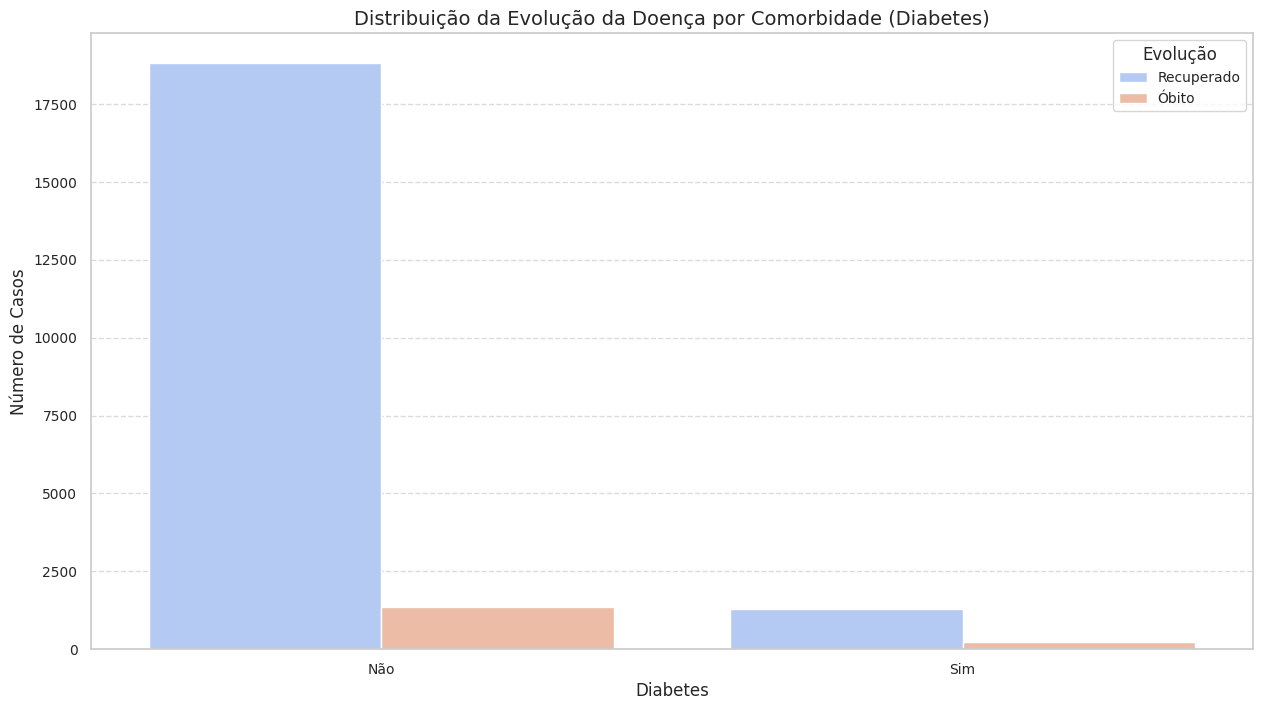

In [51]:
# Bar chart of confirmed cases by Diabetes

plt.figure(figsize=(15, 8))
ax = sns.countplot(x='DIABETES', hue='EVOLUCAO', data=data, palette='coolwarm')

# Update the legend to use the defined labels for Evolution
handles, labels = ax.get_legend_handles_labels()
new_evolution_labels = [evolution_labels[int(float(lbl))] for lbl in labels]
plt.legend(handles=handles, labels=new_evolution_labels, title="Evolução", fontsize=10)

# Update the x-axis labels for the DIABETES variable
# Assuming DIABETES is encoded as 0 and 1 and we want to display "Não" and "Sim"
current_diabetes_labels = [label.get_text() for label in ax.get_xticklabels()]
original_diabetes_order = [int(lbl) for lbl in current_diabetes_labels]
ticks = ax.get_xticks()
ax.xaxis.set_major_locator(FixedLocator(ticks))
new_diabetes_labels = [diabetes_labels[val] for val in original_diabetes_order]
ax.set_xticklabels(new_diabetes_labels, fontsize=10)

plt.title("Distribuição da Evolução da Doença por Comorbidade (Diabetes)", fontsize=14)
plt.xlabel("Diabetes", fontsize=12)
plt.ylabel("Número de Casos", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


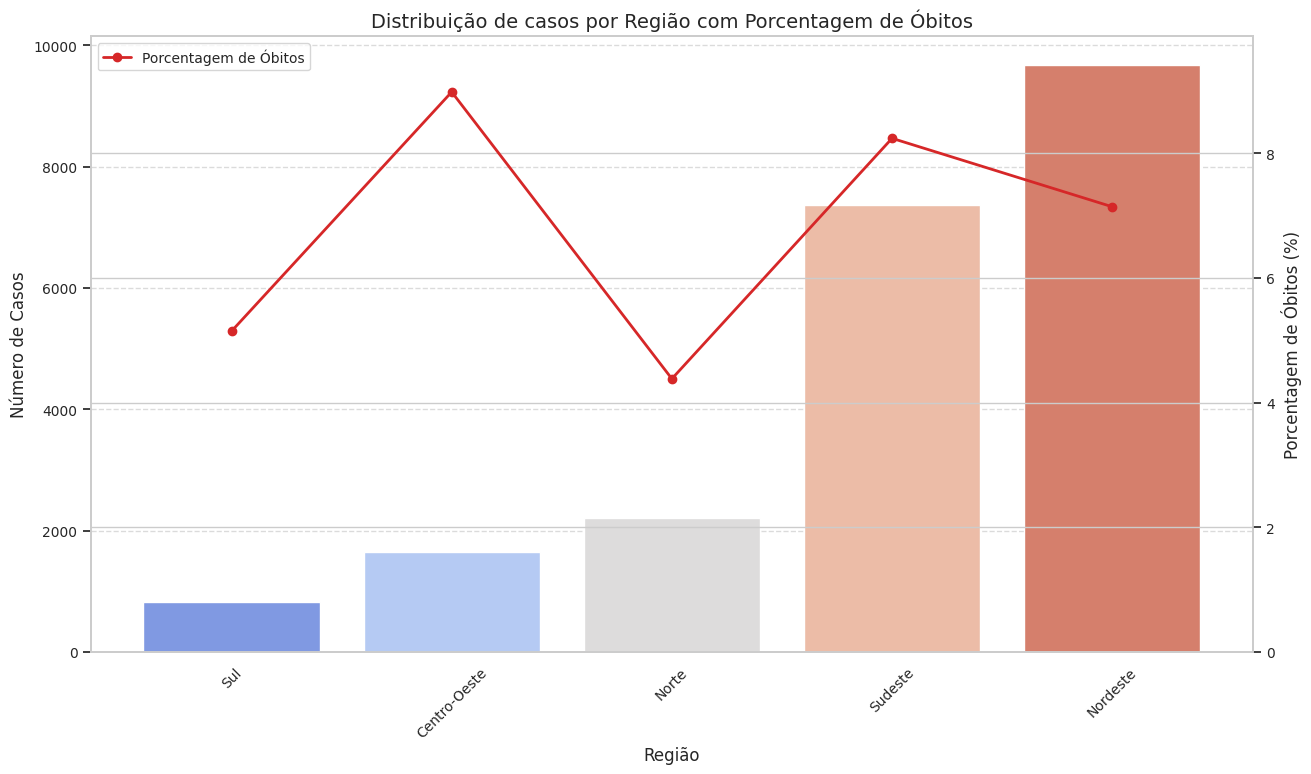

In [52]:
# Bar chart of confirmed cases by Region with percentages of Evolution to Death

# Summing up the cases for each region
region_counts = data[region_cols].sum()

# Counting evolutions for each region (cases where EVOLUCAO == 1)
region_evolution = data[region_cols + ['EVOLUCAO']].groupby('EVOLUCAO').sum().loc[1]
region_evolution_percentage = (region_evolution / region_counts) * 100

# Sorting the regions (from fewest to most cases) and aligning the percentages in the same order
region_counts_sorted = region_counts.sort_values(ascending=True)
region_evolution_percentage_sorted = region_evolution_percentage[region_counts_sorted.index]

fig, ax1 = plt.subplots(figsize=(15, 8))

# Bar chart: total number of cases per region
sns.barplot(
    x=region_counts_sorted.index, 
    y=region_counts_sorted.values, 
    hue=region_counts_sorted.index, 
    palette="coolwarm", 
    ax=ax1, 
    legend=False
)
ax1.set_xlabel("Região", fontsize=12)
ax1.set_ylabel("Número de Casos", fontsize=12)
ticks = ax1.get_xticks()
ax1.xaxis.set_major_locator(FixedLocator(ticks))
new_region_labels = [region_labels[label] for label in region_counts_sorted.index]
ax1.set_xticklabels(new_region_labels, rotation=45, fontsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Second y-axis: percentage of evolutions per region
ax2 = ax1.twinx()
ax2.plot(region_counts_sorted.index, region_evolution_percentage_sorted.values, 
         color='tab:red', marker='o', linestyle='-', linewidth=2, label="Porcentagem de Óbitos")
ax2.set_ylabel("Porcentagem de Óbitos (%)", fontsize=12)
ax2.tick_params(axis='y', labelsize=10)

# Configure the secondary axis to start at 0 and go up to the maximum value plus a 10% margin
max_pct = region_evolution_percentage_sorted.max()
ax2.set_ylim(0, max_pct * 1.1)

ax2.legend(loc='upper left', fontsize=10)

plt.title("Distribuição de casos por Região com Porcentagem de Óbitos", fontsize=14)
plt.show()


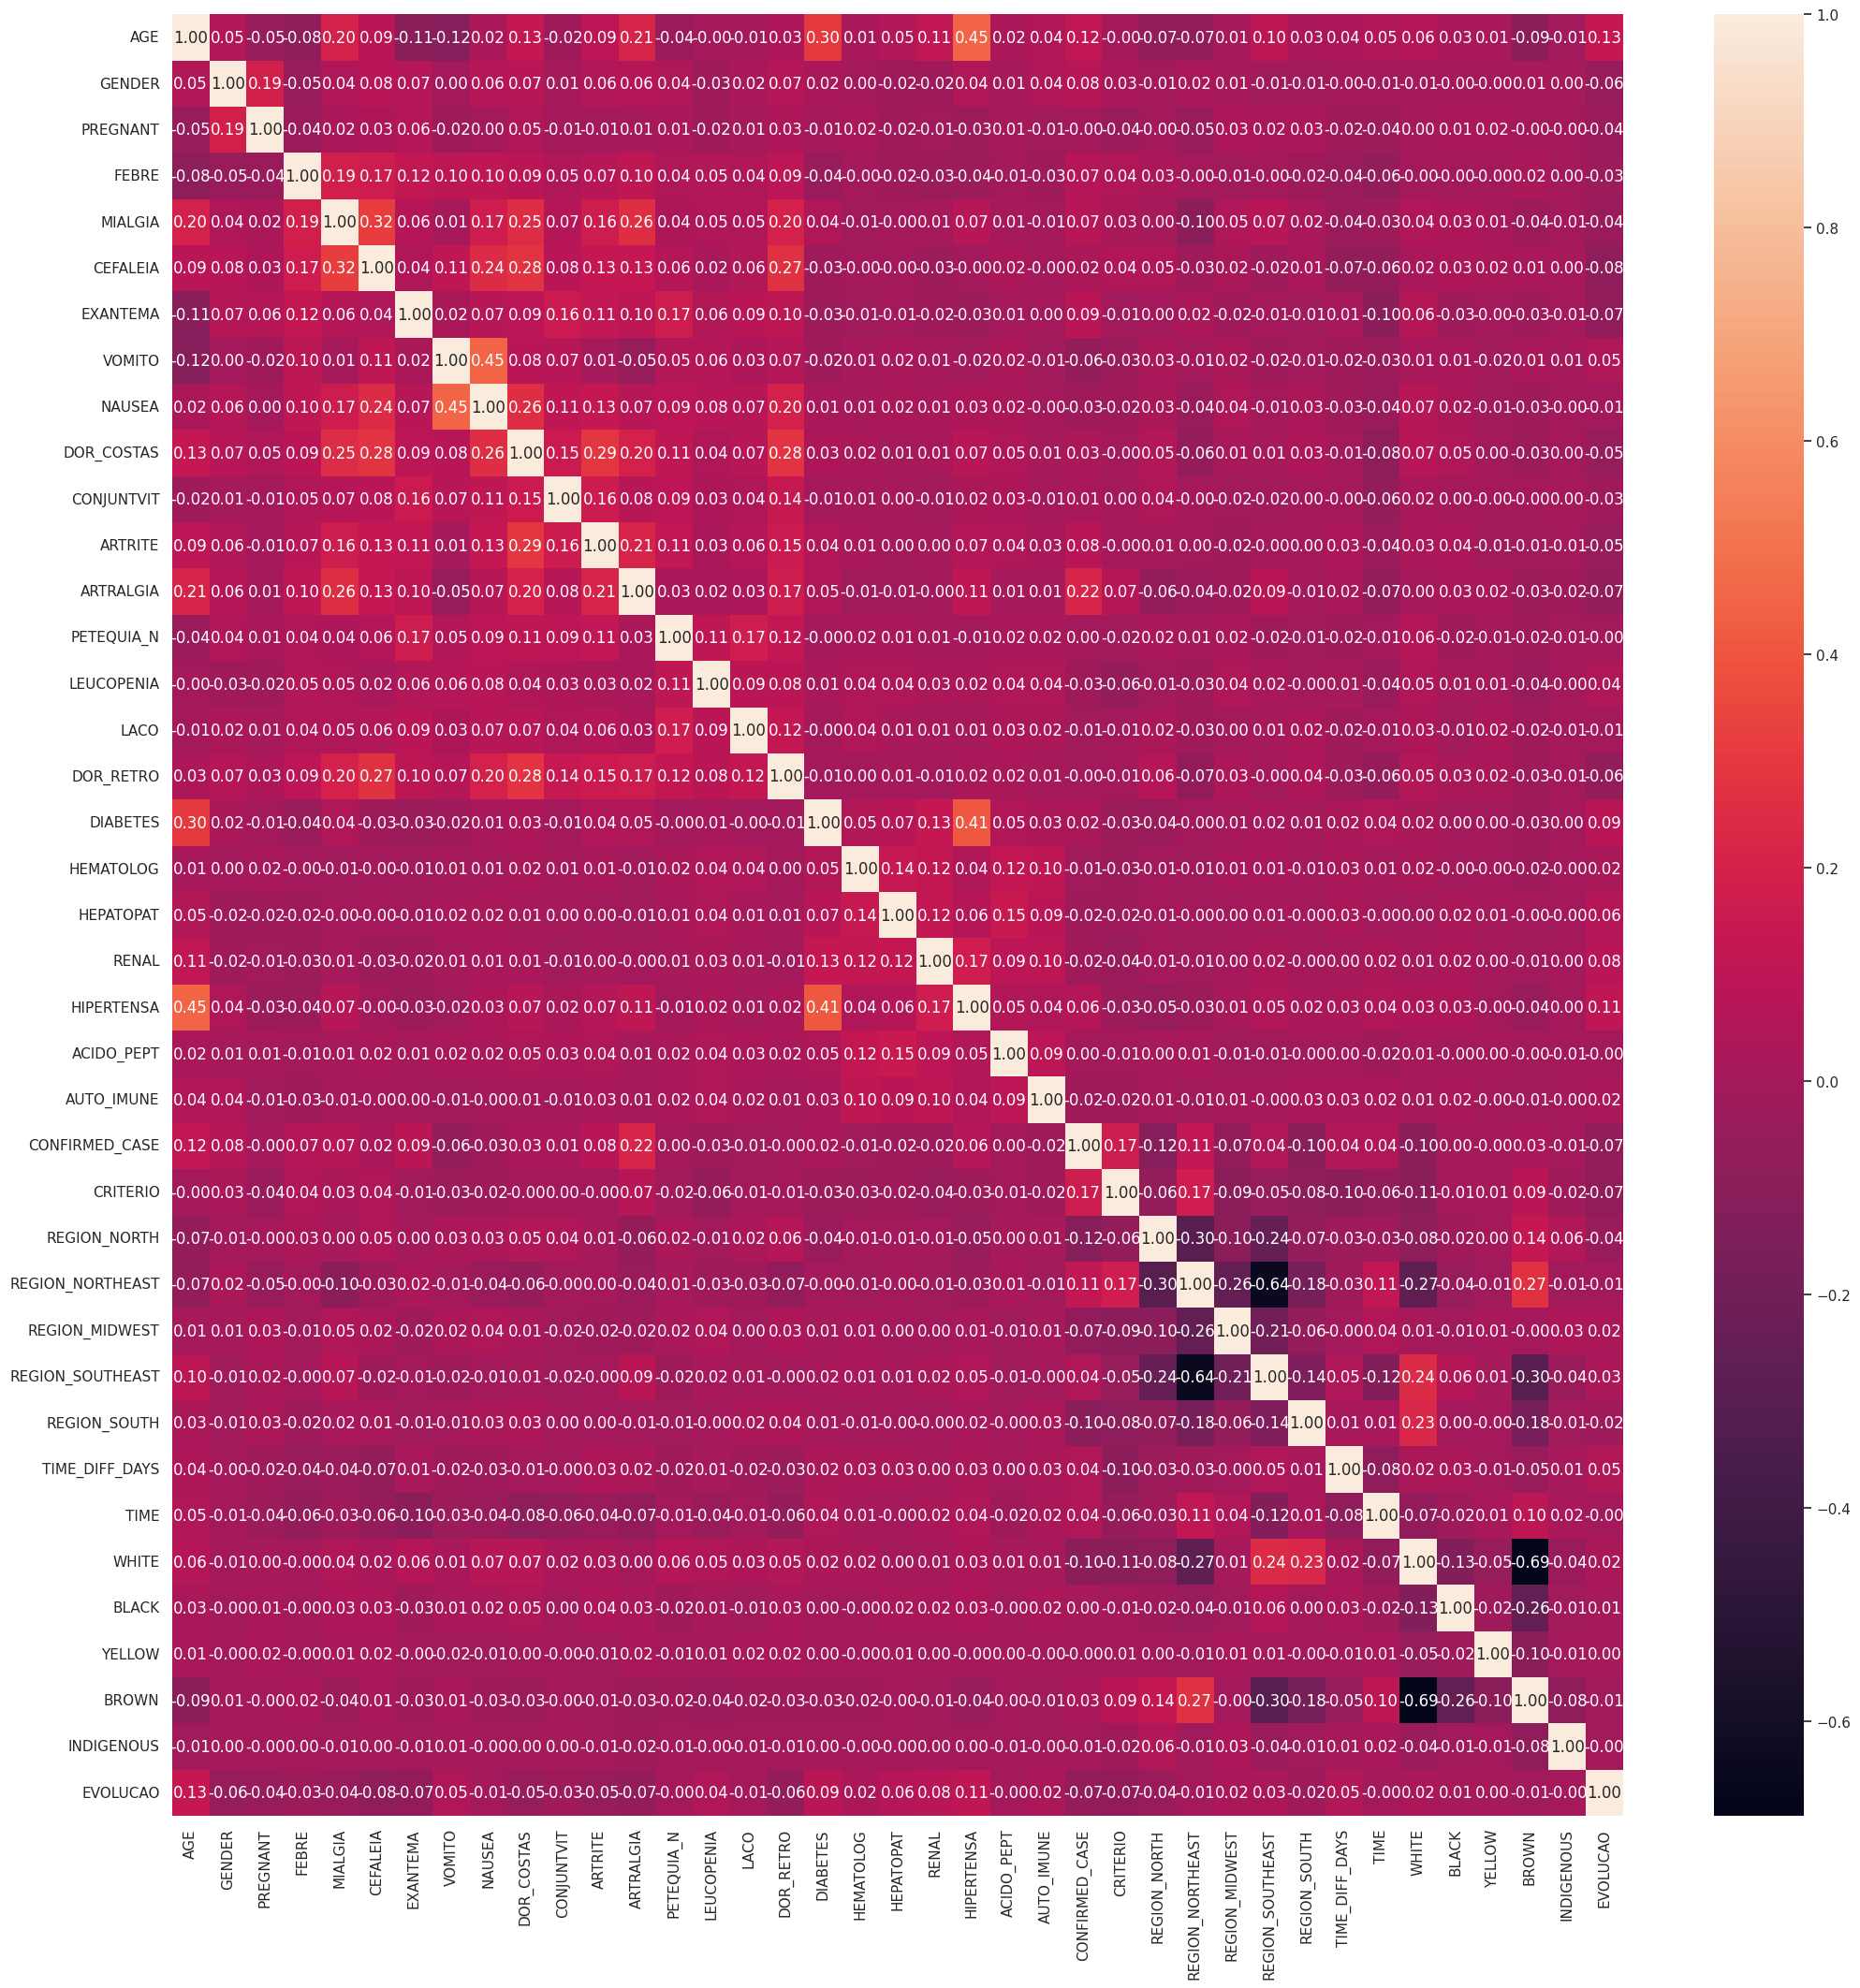

In [53]:
# Heatmap of columns in train
# Big negative correlation between one-hot encoded columns

plt.figure(figsize=(25, 25))
sns.heatmap(data.corr(), annot=True, fmt=".2f")
plt.show()